In [566]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg

from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM

from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.coordinates import concatenate
from astropy import units as u

from matplotlib.patches import Ellipse
from scipy.spatial.transform import Rotation

import treecorr
import random

import torch

In [567]:
from sbi.analysis import pairplot
from sbi.inference import NPE, SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
    prepare_for_sbi
)

In [568]:
cmass_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/galaxy_DR12v5_CMASS_North.fits')

names = [name for name in cmass_table.colnames if len(cmass_table[name].shape) <= 1]
filtered_tbl = cmass_table[names]

cmass = filtered_tbl.to_pandas()
cmass.columns

Index(['RA', 'DEC', 'RUN', 'RERUN', 'CAMCOL', 'FIELD', 'ID', 'ICHUNK', 'IPOLY',
       'ISECT', 'AIRMASS', 'EB_MINUS_V', 'IMATCH', 'Z', 'WEIGHT_FKP',
       'WEIGHT_CP', 'WEIGHT_NOZ', 'WEIGHT_STAR', 'WEIGHT_SEEING',
       'WEIGHT_SYSTOT', 'NZ', 'COMP', 'PLATE', 'FIBERID', 'MJD', 'FINALN',
       'SPECTILE', 'ICOLLIDED', 'INGROUP', 'MULTGROUP'],
      dtype='object')

In [569]:
print(len(cmass))

618806


In [570]:
unions = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/unions_shapepipe_v1.3.1.fits')
#unions = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/unions_shapepipe_cut_struc_2024_v1.4.2.1.fits')

In [571]:
names = [name for name in unions.colnames if len(unions[name].shape) <= 1]

In [572]:
filtered_tbl = unions[names]

In [573]:
unions = filtered_tbl.to_pandas()

In [574]:
print(len(unions))

83812739


In [575]:
cat_unions = SkyCoord(ra= unions['RA'], dec=unions['Dec'],unit='deg')
cat_cmass = SkyCoord(ra=cmass['RA'] , dec=cmass['DEC'] , unit='deg')
idx, d2d, d3d = match_coordinates_sky(cat_unions, cat_cmass)
unions_cmass_cross = unions.loc[d2d.value < 0.00010]

In [452]:
print(len(unions_cmass_cross))
nb_unions_cmass = len(unions_cmass_cross)

74978


In [453]:
unions_cmass_index = unions_cmass_cross.index
unions_cmass_index=np.array(unions_cmass_index)

In [576]:
def get_galaxy_orientation_angle(e1,e2):
    return 0.5*np.arctan2(e2,e1)

def abs_e(e1,e2):
    return np.sqrt(e1*e1+e2*e2)

def a_b(e1,e2):
    e = abs_e(e1,e2)
    return 1+e,1-e  

def e_complex(a,b,r):
    abs_e = (1-(b/a)) / (1+(b/a))
    e1 = abs_e*np.cos(2*r)
    e2 = abs_e*np.sin(2*r)
    return e1, e2

In [577]:
# DATA : CMASS galaxies

a = np.zeros(len(unions_cmass_cross)) ; b = np.zeros(len(unions_cmass_cross)); theta = np.zeros(len(unions_cmass_cross))
axis_ratio_cmass = np.zeros(len(unions_cmass_cross))
e1cmass = np.zeros(len(unions_cmass_cross)) ; e2cmass = np.zeros(len(unions_cmass_cross)) ; ecmass = np.zeros(len(unions_cmass_cross))

for i in range (len(unions_cmass_cross)):
    a[i],b[i] = a_b(unions_cmass_cross['e1'][unions_cmass_index[i]],unions_cmass_cross['e2'][unions_cmass_index[i]])
    axis_ratio_cmass[i] = a[i]/b[i]
    theta[i] = get_galaxy_orientation_angle(unions_cmass_cross['e1'][unions_cmass_index[i]],unions_cmass_cross['e2'][unions_cmass_index[i]])
    e1cmass[i],e2cmass[i] = e_complex(a[i],b[i],theta[i])
    ecmass[i] = abs_e(e1cmass[i],e2cmass[i])

In [578]:
# SIMULATION : function that returns the projected ellipticity (2D) of nb_simu simulated ellipsoidal galaxies (3D) with random orientations 
# = 1 simulation

def simulation(theta , nb_galaxies=nb_unions_cmass, p_axis='y', A=1,e_bins=np.linspace(0,1,50)):

    mu_B, mu_C, sigma_B, sigma_C, r = theta

    # Random (gaussian) axis lengths B,C
    BC = np.random.multivariate_normal(mean=[mu_B, mu_C], cov=[[sigma_B**2, r*sigma_B*sigma_C], [r*sigma_B*sigma_C, sigma_C**2]], size=nb_galaxies)
    mask = (BC[:,0]/A<=1) & (BC[:,1]/ A<=1) & (BC[:,0] >= BC[:,1]) & (BC[:,0]>0) & (BC[:,1]>0)
    BC2 = BC[mask]

    B=BC2[:,0] ; C=BC2[:,1]
    A=np.ones(len(BC2)) # A fixed to 1

    nb_galaxies=len(BC2)


    # Random orientation angles
    if nb_galaxies > 0:
        rand_quat = np.random.randn(nb_galaxies,4) ; rand_quat /= np.linalg.norm(rand_quat, axis=1, keepdims=True)
        rotation = Rotation.from_quat(rand_quat) ; euler_angles = rotation.as_euler('ZYX', degrees=True)
        euler_angles_rad = euler_angles*np.pi/180
        psi = euler_angles_rad[:,0]; theta = euler_angles_rad[:,1] ; phi = euler_angles_rad[:,2]
    else:
        return np.zeros_like(e_bins[:-1])
    
    # Rotation matrix
    D = np.zeros((nb_galaxies, 3, 3))

    D[:, 0, 0] = np.cos(theta) * np.cos(psi)
    D[:, 0, 1] = -np.cos(phi) * np.sin(psi) + np.sin(phi) * np.sin(theta) * np.cos(psi)
    D[:, 0, 2] = np.sin(phi) * np.sin(psi) + np.cos(phi) * np.sin(theta) * np.cos(psi)

    D[:, 1, 0] = np.cos(theta) * np.sin(psi)
    D[:, 1, 1] = np.cos(phi) * np.cos(psi) + np.sin(phi) * np.sin(theta) * np.sin(psi)
    D[:, 1, 2] = -np.sin(phi) * np.cos(psi) + np.cos(phi) * np.sin(theta) * np.sin(psi)

    D[:, 2, 0] = -np.sin(theta)
    D[:, 2, 1] = np.sin(phi) * np.cos(theta)
    D[:, 2, 2] = np.cos(phi) * np.cos(theta)



    #Eigenvectors X-Y-Z
    evc0 = np.asarray([[1,0,0],[0,1,0],[0,0,1]])
    evcl = np.einsum('ijk,kl->ijl', D, evc0)


    #Eigenvalues Maj-Mid-Min
    evls = np.array([A,B,C])**2 ; evls=np.transpose(evls)


    # Projection 3D => 2D
    if p_axis=='x':
        K = np.sum(evcl[:,:,0][:,:,None]*(evcl/evls[:,None]), axis=1)
        r = evcl[:,:,2] - evcl[:,:,0] * K[:,2][:,None] / K[:,0][:,None]
        s = evcl[:,:,1] - evcl[:,:,0] * K[:,1][:,None] / K[:,0][:,None] 

    if p_axis=='y':
        K = np.sum(evcl[:,:,1][:,:,None] * (evcl/evls[:,None]), axis=1)
        r = evcl[:,:,0] - evcl[:,:,1] * K[:,0][:,None] / K[:,1][:,None]
        s = evcl[:,:,2] - evcl[:,:,1] * K[:,2][:,None] / K[:,1][:,None]

    A1 = np.sum(r**2 / evls, axis=1)
    B1 = np.sum(2*r*s / evls, axis=1)
    C1 = np.sum(s**2 / evls, axis=1)

    theta = np.pi / 2 + np.arctan2(B1,A1-C1)/2
    a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*theta)))
    b_p = 1/np.sqrt(A1+C1-(1/a_p**2))

    def e_complex(a,b,r):
        abs_e = (1-(b/a)) / (1+(b/a))
        e1 = abs_e*np.cos(2*r)
        e2 = abs_e*np.sin(2*r)
        return e1, e2

    e1, e2 = e_complex(a_p, b_p, theta) ; e = [e1,e2] ; e=np.array(e)

    e_counts,_ = np.histogram(np.sqrt(e[0,:]**2+e[1,:]**2),bins=e_bins)
    
    return e_counts/nb_galaxies

In [579]:
prior = BoxUniform(
    low=torch.tensor([0.3, 0.3, 0,   0,  -0.8]),
    high=torch.tensor([1,  1,   0.2, 0.2, 0.8])
)

In [586]:
posterior = infer(simulation, 
                             prior, 
                             method = 'NPE', 
                             num_simulations = 60000 , 
                             num_workers = 40 )

100%|██████████| 60000/60000 [09:59<00:00, 100.02it/s]


 Neural network successfully converged after 219 epochs.

(1, 49)


Drawing 30000 posterior samples: 30004it [00:00, 33038.52it/s]                           


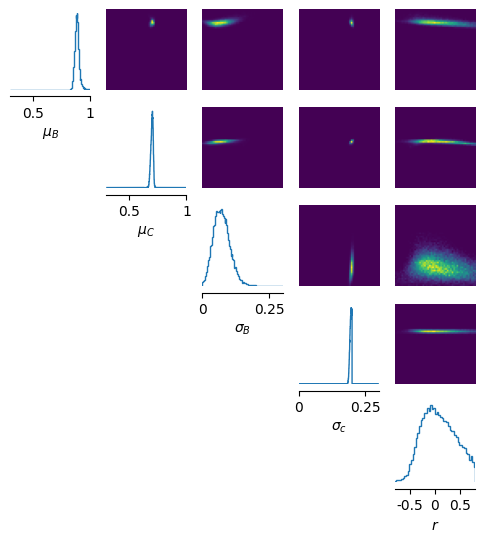

In [587]:
e_bins=np.linspace(0,1,50)
e_cents = (e_bins[1:]+e_bins[:-1])/2.

e_data_counts,_ = np.histogram(ecmass, bins = e_bins) 

e_counts_data = [e_data_counts] ; e_counts_data=np.array(e_counts_data)
print(e_counts_data.shape)

x_obs = e_counts_data/nb_unions_cmass

samples = posterior.sample((30000,), x=x_obs)

pairplot(samples,
             limits=[[0.3,1], [0.3,1], [0,0.3], [0,0.3], [-0.8,0.8]],
             figsize=(6, 6),
             labels=[r"$\mu_B$", r"$\mu_C$", r"$\sigma_B$", r"$\sigma_c$", r"$r$"],
             )

plt.savefig("3D_morphology.pdf")

[0.88317436 0.69943696 0.07090379 0.1948759  0.08082359]


Text(0, 0.5, 'Normalized count')

<Figure size 1000x700 with 0 Axes>

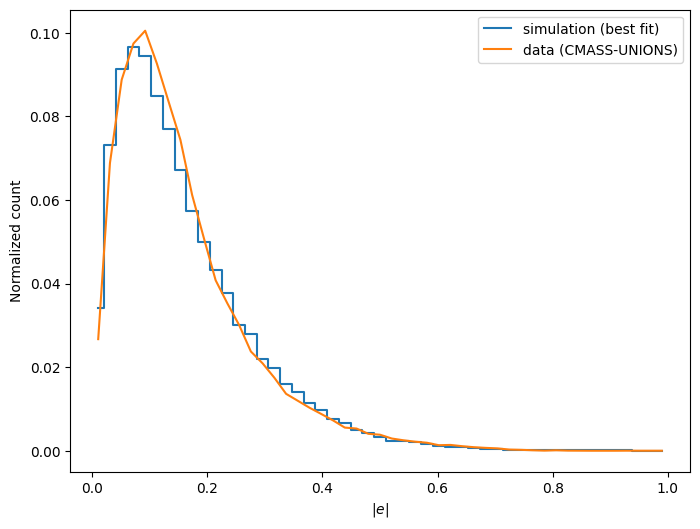

In [588]:
theta_estimated=np.mean(samples.numpy(), axis=0) ; print(theta_estimated)

mu_B, mu_C, sigma_B, sigma_C, r = theta_estimated[0], theta_estimated[1], theta_estimated[2], theta_estimated[3], theta_estimated[4]

x_estimated = simulation([mu_B, mu_C, sigma_B, sigma_C, r])

plt.figure( figsize = (10,7) )
plt.figure(figsize=(8,6))
plt.plot(e_cents,x_estimated,drawstyle='steps-mid',label='simulation (best fit)')
plt.plot(e_cents,e_data_counts/nb_unions_cmass,label="data (CMASS-UNIONS)")
plt.legend()
plt.xlabel(r"$\vert e \vert$")
plt.ylabel("Normalized count")
#plt.savefig("cmass.pdf")

(10000, 2)


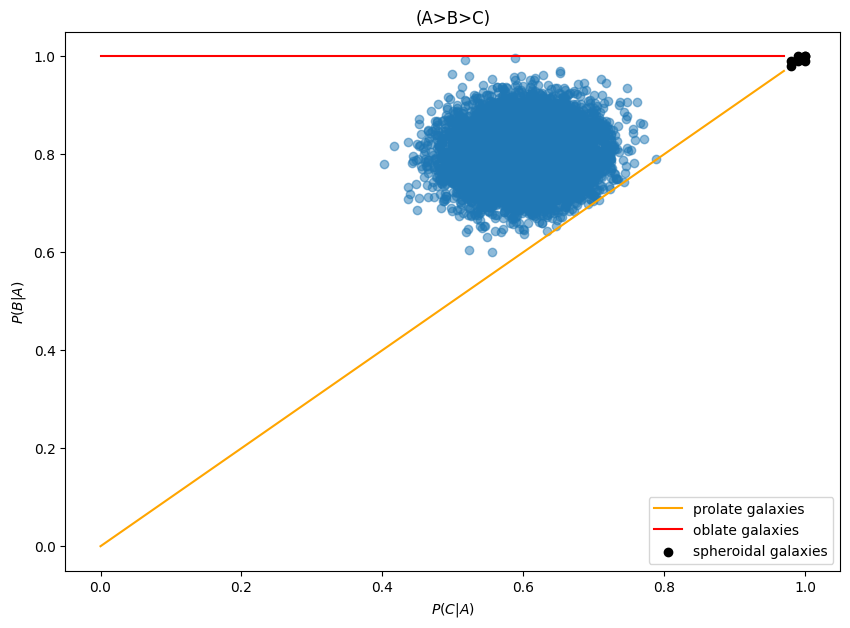

In [585]:
# Distribution of B,C (convention A=1>B>C)

A=1 ; nb_galaxies = 10000

# Model = {mu_B, mu_C, sigma_B, sigma_C}
mu_B=0.8; mu_C=0.6; sigma_B=0.05; sigma_C=0.05; r=0.01


BC = np.random.multivariate_normal(mean=[mu_B,mu_C],cov=[[sigma_B**2,r**2],[r**2,sigma_C**2]],size=nb_galaxies)
print(BC.shape)

# remove B/A>1, C/A>1, C>B, B<0, C<0
# B => BC[0,0] ; C => BC[0,1]
BC2=[]
for i in range (len(BC)):
    if BC[i,0]/A<=1 and BC[i,1]/A<=1 and BC[i,0]>=BC[i,1] and BC[i,0]>0 and BC[i,1]>0:
        BC2.append([BC[i,0],BC[i,1]])
BC2=np.array(BC2)


plt.figure( figsize = (10,7) )
plt.scatter(BC2[:,1]/A,BC2[:,0]/A,alpha=0.5)
plt.xlabel(r"$P(C \vert A)$") ; plt.ylabel(r"$P(B \vert A)$")
plt.title("(A>B>C)")

x=np.linspace(0,0.97,30) ; y=x
plt.plot(x, y,color='orange',label='prolate galaxies')
plt.plot(x, np.ones(len(x)),color='red',label='oblate galaxies')
plt.scatter([0.99,1,0.99,1,0.98,0.98,1],[0.99,1,1,0.99,0.98,0.99,1],color='black',label='spheroidal galaxies')
plt.legend()
#plt.savefig("Population.pdf")

<Figure size 1000x700 with 0 Axes>

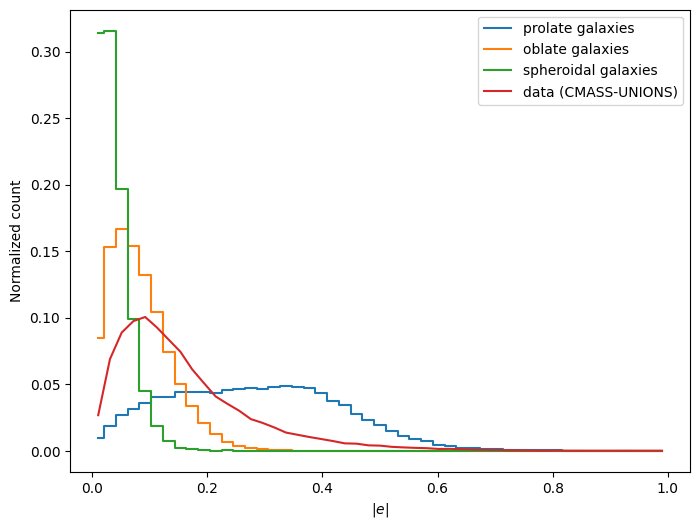

In [552]:
x_estimated1 = simulation([0.4, 0.4, 0.1, 0.1, 0.01])
x_estimated2 = simulation([1, 0.8, 0.1, 0.1, 0.01])
x_estimated3 = simulation([1, 1, 0.1, 0.1, 0.01])


plt.figure( figsize = (10,7) )
plt.figure(figsize=(8,6))
plt.plot(e_cents,x_estimated1,drawstyle='steps-mid',label='prolate galaxies')
plt.plot(e_cents,x_estimated2,drawstyle='steps-mid',label='oblate galaxies')
plt.plot(e_cents,x_estimated3,drawstyle='steps-mid',label='spheroidal galaxies')
plt.plot(e_cents,e_data_counts/nb_unions_cmass,label="data (CMASS-UNIONS)")
plt.legend()
plt.xlabel(r"$\vert e \vert$")
plt.ylabel("Normalized count")
plt.savefig("P(e).pdf")

In [ ]:
mu_B=0.807339 ; mu_C=0.81011087 ; sigma_B=0.60201675 ; sigma_C=0.53016275 ; r=0.11234327 ; A=1 ; nb_galaxies = 200000 ; e_bins=np.linspace(0,1,100)
                                    
                                    

# Random (gaussian) axis lengths B,C
BC = np.random.multivariate_normal(mean=[mu_B, mu_C], cov=[[sigma_B**2, r], [r, sigma_C**2]], size=nb_galaxies)
mask = (BC[:,0]/A<=1) & (BC[:,1]/ A<=1) & (BC[:,0] >= BC[:,1]) & (BC[:,0]>0) & (BC[:,1]>0)
BC2 = BC[mask]

B=BC2[:,0] ; C=BC2[:,1]
A=np.ones(len(BC2)) # A fixed to 1

nb_galaxies=len(BC2)


    # Random orientation angles
rand_quat = np.random.randn(nb_galaxies,4) ; rand_quat /= np.linalg.norm(rand_quat, axis=1, keepdims=True)
rotation = Rotation.from_quat(rand_quat) ; euler_angles = rotation.as_euler('ZYX', degrees=True)
euler_angles_rad = euler_angles*np.pi/180
psi = euler_angles_rad[:,0]; theta = euler_angles_rad[:,1] ; phi = euler_angles_rad[:,2]

    
    # Rotation matrix
D = np.zeros((nb_galaxies, 3, 3))

D[:, 0, 0] = np.cos(theta) * np.cos(psi)
D[:, 0, 1] = -np.cos(phi) * np.sin(psi) + np.sin(phi) * np.sin(theta) * np.cos(psi)
D[:, 0, 2] = np.sin(phi) * np.sin(psi) + np.cos(phi) * np.sin(theta) * np.cos(psi)

D[:, 1, 0] = np.cos(theta) * np.sin(psi)
D[:, 1, 1] = np.cos(phi) * np.cos(psi) + np.sin(phi) * np.sin(theta) * np.sin(psi)
D[:, 1, 2] = -np.sin(phi) * np.cos(psi) + np.cos(phi) * np.sin(theta) * np.sin(psi)

D[:, 2, 0] = -np.sin(theta)
D[:, 2, 1] = np.sin(phi) * np.cos(theta)
D[:, 2, 2] = np.cos(phi) * np.cos(theta)



    #Eigenvectors X-Y-Z
evc0 = np.asarray([[1,0,0],[0,1,0],[0,0,1]])
evcl = np.einsum('ijk,kl->ijl', D, evc0)


    #Eigenvalues Maj-Mid-Min
evls = np.array([A,B,C])**2 ; evls=np.transpose(evls)


K = np.sum(evcl[:,:,1][:,:,None] * (evcl/evls[:,None]), axis=1)
r = evcl[:,:,0] - evcl[:,:,1] * K[:,0][:,None] / K[:,1][:,None]
s = evcl[:,:,2] - evcl[:,:,1] * K[:,2][:,None] / K[:,1][:,None]

A1 = np.sum(r**2 / evls, axis=1)
B1 = np.sum(2*r*s / evls, axis=1)
C1 = np.sum(s**2 / evls, axis=1)

theta = np.pi / 2 + np.arctan2(B1,A1-C1)/2
a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*theta)))
b_p = 1/np.sqrt(A1+C1-(1/a_p**2))

def e_complex(a,b,r):
    abs_e = (1-(b/a)) / (1+(b/a))
    e1 = abs_e*np.cos(2*r)
    e2 = abs_e*np.sin(2*r)
    return e1, e2

e1, e2 = e_complex(a_p, b_p, theta) ; e = [e1,e2] ; e=np.array(e)

e_counts,_ = np.histogram(np.sqrt(e[0,:]**2+e[1,:]**2),bins=e_bins)

In [294]:
# Comparison P(e) data and simu
#[0.807339   0.81011087 0.60201675 0.53016275 0.11234327]


e_simu, es_simu_counts = simulation(mu_B=0.807339,
                                    mu_C=0.81011087,
                                    sigma_B=0.60201675,
                                    sigma_C=0.53016275,
                                    r=0.11234327,
                                    nb_galaxies=200000,
                                    p_axis='y',
                                    A=1)

e_bins = np.linspace(0,1,100)
e_cents = (e_bins[1:]+e_bins[:-1])/2.

e_data_counts,_ = np.histogram(ecmass, bins = e_bins) 

e_counts_data = [e_data_counts] ; e_counts_data=np.array(e_counts_data)
print(e_counts_data.shape)

plt.figure( figsize = (10,7) )
plt.figure(figsize=(8,6))
plt.plot(e_cents,es_simu_counts/len(e_simu[0,:]),drawstyle='steps-mid',label='simulation')
plt.plot(e_cents,e_data_counts/nb_unions_cmass,label="data (CMASS-UNIONS)")
plt.legend()
plt.xlabel(r"$\vert e \vert$")
plt.ylabel("Normalized count")


theta_estimated = [[0.72,0.72,0.21,0.21,0.01]]

ValueError: too many values to unpack (expected 2)

Text(0, 0.5, 'Normalized count')

<Figure size 1000x700 with 0 Axes>

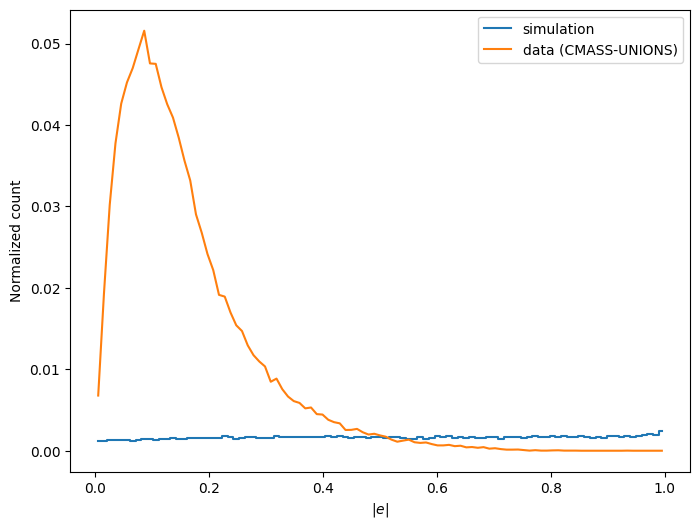

In [103]:
# e_simu, es_simu_counts = simulator(mu_B=0.807339,
#                                     mu_C=0.81011087,
#                                     sigma_B=0.60201675,
#                                     sigma_C=0.53016275,
#                                     r=0.11234327,
#                                     nb_galaxies=200000,
#                                     p_axis='y',
#                                     A=1)

e_bins = np.linspace(0,1,100)
e_cents = (e_bins[1:]+e_bins[:-1])/2.

e_data_counts,_ = np.histogram(ecmass, bins = e_bins) 

e_counts_data = [e_data_counts] ; e_counts_data=np.array(e_counts_data)
#print(e_counts_data.shape)

plt.figure( figsize = (10,7) )
plt.figure(figsize=(8,6))
plt.plot(e_cents,e_counts[0,:]/len(e[0,0,:]),drawstyle='steps-mid',label='simulation')
plt.plot(e_cents,e_data_counts/nb_unions_cmass,label="data (CMASS-UNIONS)")
plt.legend()
plt.xlabel(r"$\vert e \vert$")
plt.ylabel("Normalized count")

In [217]:
# Dimension BC : (nb_simu, nb_galaxies_par_simu, 2)


def simulator(model, nb_simulations, nb_galaxies, p_axis='y', A=1, e_bins=np.linspace(0,1,100)):

    mu_B, mu_C, sigma_B, sigma_C, r = model[:,0],model[:,1],model[:,2],model[:,3],model[:,4]
        
    # Préparation de la covariance sous forme matricielle pour chaque ensemble de paramètres
    cov_matrix = np.array([[[sigma_b**2, r_], [r_, sigma_c**2]] for sigma_b, r_, sigma_c in zip(sigma_B, r, sigma_C)])

    # Génération des échantillons multivariés pour tous les ensembles de paramètres à la fois
    BC = np.array([np.random.multivariate_normal(mean=[mu_b, mu_c], cov=cov, size=nb_galaxies) 
                for mu_b, mu_c, cov in zip(mu_B, mu_C, cov_matrix)])

    # Applis du masque à l'ensemble des échantillons
    mask = (BC[:,:,0] > 0) & (BC[:,:,1] > 0) & (BC[:,:,0] / A < 1) & (BC[:,:,1] / A < 1) & (BC[:,:,1] < BC[:,:,0])

    BC2 = [bc[mask] for bc, mask in zip(BC, mask)]
    BC2 = np.array(BC2)

    B = BC2[:,:,0]
    C = BC2[:,:,1] 

    A = np.ones(B.shape) # A fixed to 1

    nb_galaxies=len(BC2[0,:,0])

    # Random orientations
    rand_quat = np.random.randn(nb_simulations,nb_galaxies,4)
    rand_quat /= np.linalg.norm(rand_quat, axis=2, keepdims=True)
    rotation = Rotation.from_quat(rand_quat.reshape(-1,4))
    euler_angles = rotation.as_euler('ZYX', degrees=True)
    euler_angles_rad = euler_angles*np.pi/180
    euler_angles_rad = euler_angles_rad.reshape(nb_simulations, nb_galaxies, 3)
    psi = euler_angles_rad[:,:,0]; theta = euler_angles_rad[:,:,1] ; phi = euler_angles_rad[:,:,2]


    D = np.zeros((nb_simulations,nb_galaxies, 3, 3))

    D[:,:, 0, 0] = np.cos(theta) * np.cos(psi)
    D[:,:, 0, 1] = -np.cos(phi) * np.sin(psi) + np.sin(phi) * np.sin(theta) * np.cos(psi)
    D[:,:, 0, 2] = np.sin(phi) * np.sin(psi) + np.cos(phi) * np.sin(theta) * np.cos(psi)

    D[:,:, 1, 0] = np.cos(theta) * np.sin(psi)
    D[:,:, 1, 1] = np.cos(phi) * np.cos(psi) + np.sin(phi) * np.sin(theta) * np.sin(psi)
    D[:,:, 1, 2] = -np.sin(phi) * np.cos(psi) + np.cos(phi) * np.sin(theta) * np.sin(psi)

    D[:,:, 2, 0] = -np.sin(theta)
    D[:,:, 2, 1] = np.sin(phi) * np.cos(theta)
    D[:,:, 2, 2] = np.cos(phi) * np.cos(theta)


    #Eigenvectors X-Y-Z
    evc0 = np.asarray([[1,0,0],[0,1,0],[0,0,1]])
    evcl = np.einsum('ijkl,kl->ijkl', D, evc0) 


    #Eigenvalues Maj-Mid-Min
    evls = np.array([A,B,C])**2 ; evls=np.transpose(evls,(1,2,0)) 

    if p_axis=='x':
        K = np.sum(evcl[:,:,:,0][:,:,:,None] * (evcl/evls[:,:,None]), axis=2) 
        r = evcl[:,:,:,2] - evcl[:,:,:,0] * K[:,:,2][:,:,None] / K[:,:,0][:,:,None] 
        s = evcl[:,:,:,1] - evcl[:,:,:,0] * K[:,:,1][:,:,None] / K[:,:,0][:,:,None] 


    if p_axis=='y':
        K = np.sum(evcl[:,:,:,1][:,:,:,None] * (evcl/evls[:,:,None]), axis=2) 
        r = evcl[:,:,:,0] - evcl[:,:,:,1] * K[:,:,0][:,:,None] / K[:,:,1][:,:,None] 
        s = evcl[:,:,:,2] - evcl[:,:,:,1] * K[:,:,2][:,:,None] / K[:,:,1][:,:,None] 


    #print(r.shape) ; print(s.shape)
    A1 = np.nansum(r**2 / evls, axis=2)
    B1 = np.nansum(2*r*s / evls, axis=2) 
    C1 = np.nansum(s**2 / evls, axis=2)

    theta = np.pi / 2 + np.arctan2(B1,A1-C1)/2 
    a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*theta))) 
    b_p = 1/np.sqrt(A1+C1-(1/a_p**2)) 

    def e_complex(a,b,r):
        abs_e = (1-(b/a)) / (1+(b/a))
        e1 = abs_e*np.cos(2*r)
        e2 = abs_e*np.sin(2*r)
        return e1, e2

    e1, e2 = e_complex(a_p, b_p, theta) ; e = [e1,e2] ; e=np.array(e) ; e=np.transpose(e,(1,0,2))

    e_magnitude = np.sqrt(e[:,0,:]**2 + e[:,1,:]**2)

    e_counts = np.apply_along_axis(lambda x: np.histogram(x, bins=e_bins)[0], axis=1, arr=e_magnitude)

    return e_counts/nb_galaxies

In [218]:
nb_simulations=1 ; nb_galaxies=nb_unions_cmass ; model=np.array([[0.72,0.72,0.21,0.21,0.01],[0.7,0.7,0.1,0.1,0.01]]) ; e_bins=np.linspace(0,1,100) ; A=1

mu_B, mu_C, sigma_B, sigma_C, r = model[:,0],model[:,1],model[:,2],model[:,3],model[:,4]
        
    # Préparation de la covariance sous forme matricielle pour chaque ensemble de paramètres
cov_matrix = np.array([[[sigma_b**2, r_], [r_, sigma_c**2]] for sigma_b, r_, sigma_c in zip(sigma_B, r, sigma_C)])

    # Génération des échantillons multivariés pour tous les ensembles de paramètres à la fois
BC = np.array([np.random.multivariate_normal(mean=[mu_b, mu_c], cov=cov, size=nb_galaxies) 
                for mu_b, mu_c, cov in zip(mu_B, mu_C, cov_matrix)])

# Applis du masque à l'ensemble des échantillons
mask = (BC[:,:,0] > 0) & (BC[:,:,1] > 0) & (BC[:,:,0] / A < 1) & (BC[:,:,1] / A < 1) & (BC[:,:,1] < BC[:,:,0])


BC2 = np.array([bc[mask] for bc, mask in zip(BC, mask)])
BC2 = np.array(BC2)


B = BC2[:,:,0]
C = BC2[:,:,1] 

A = np.ones(B.shape) # A fixed to 1


nb_galaxies=len(BC2[0,:,0]) ; print(nb_galaxies)


# Random orientations
rand_quat = np.random.randn(nb_simulations,nb_galaxies,4)
rand_quat /= np.linalg.norm(rand_quat, axis=2, keepdims=True)
rotation = Rotation.from_quat(rand_quat.reshape(-1,4))
euler_angles = rotation.as_euler('ZYX', degrees=True)
euler_angles_rad = euler_angles*np.pi/180
euler_angles_rad = euler_angles_rad.reshape(nb_simulations, nb_galaxies, 3)
psi = euler_angles_rad[:,:,0]; theta = euler_angles_rad[:,:,1] ; phi = euler_angles_rad[:,:,2]


D = np.zeros((nb_simulations,nb_galaxies, 3, 3))

D[:,:, 0, 0] = np.cos(theta) * np.cos(psi)
D[:,:, 0, 1] = -np.cos(phi) * np.sin(psi) + np.sin(phi) * np.sin(theta) * np.cos(psi)
D[:,:, 0, 2] = np.sin(phi) * np.sin(psi) + np.cos(phi) * np.sin(theta) * np.cos(psi)

D[:,:, 1, 0] = np.cos(theta) * np.sin(psi)
D[:,:, 1, 1] = np.cos(phi) * np.cos(psi) + np.sin(phi) * np.sin(theta) * np.sin(psi)
D[:,:, 1, 2] = -np.sin(phi) * np.cos(psi) + np.cos(phi) * np.sin(theta) * np.sin(psi)

D[:,:, 2, 0] = -np.sin(theta)
D[:,:, 2, 1] = np.sin(phi) * np.cos(theta)
D[:,:, 2, 2] = np.cos(phi) * np.cos(theta)

print(D.shape)

#Eigenvectors X-Y-Z
evc0 = np.asarray([[1,0,0],[0,1,0],[0,0,1]])
evcl = np.einsum('ijkl,kl->ijkl', D, evc0) 


#Eigenvalues Maj-Mid-Min
evls = np.array([A,B,C])**2 ; evls=np.transpose(evls,(1,2,0)) 


K = np.sum(evcl[:,:,:,1][:,:,:,None] * (evcl/evls[:,:,None]), axis=2) 
r = evcl[:,:,:,0] - evcl[:,:,:,1] * K[:,:,0][:,:,None] / K[:,:,1][:,:,None] 
s = evcl[:,:,:,2] - evcl[:,:,:,1] * K[:,:,2][:,:,None] / K[:,:,1][:,:,None] 


#print(r.shape) ; print(s.shape)
A1 = np.sum(r**2 / evls, axis=2)
B1 = np.sum(2*r*s / evls, axis=2) 
C1 = np.sum(s**2 / evls, axis=2)


theta = np.pi / 2 + np.arctan2(B1,A1-C1)/2 
a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*theta))) 
b_p = 1/np.sqrt(A1+C1-(1/a_p**2)) 

def e_complex(a,b,r):
    abs_e = (1-(b/a)) / (1+(b/a))
    e1 = abs_e*np.cos(2*r)
    e2 = abs_e*np.sin(2*r)
    return e1, e2

e1, e2 = e_complex(a_p, b_p, theta) ; e = [e1,e2] ; e=np.array(e) ; e=np.transpose(e,(1,0,2))

e_magnitude = np.sqrt(e[:,0,:]**2 + e[:,1,:]**2)  # (nb_simulations, nb_galaxies)
e_counts = np.apply_along_axis(lambda x: np.histogram(x, bins=e_bins)[0], axis=1, arr=e_magnitude)

plt.figure( figsize = (10,7) )
plt.figure(figsize=(8,6))
plt.plot(e_cents,e_counts[0,:]/nb_galaxies,drawstyle='steps-mid',label='simulation')
plt.plot(e_cents,e_data_counts/nb_galaxies,label="data (CMASS-UNIONS)")
plt.legend()
plt.xlabel(r"$\vert e \vert$")
plt.ylabel("Normalized count")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [262]:
prior = BoxUniform(
    low=torch.tensor([0, 0, 0, 0, 0]),
    high=torch.tensor([1, 1, 1, 1, 1])
)

In [137]:
theta = torch.tensor(theta, dtype=torch.float32) ; x = torch.tensor(x, dtype=torch.float32)

inference = NPE(prior=prior)
inference = inference.append_simulations(theta, x)

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_40090/1837378514.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32) ; x = torch.tensor(x, dtype=torch.float32)


In [138]:
density_estimator = inference.train()

 Neural network successfully converged after 129 epochs.

In [139]:
posterior = inference.build_posterior(density_estimator)

print(posterior)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [140]:
# Method 1  : taking the data directly to infer the posterior
x_obs = e_counts_data/nb_unions_cmass

Drawing 3000 posterior samples: 3929it [00:00, 20166.30it/s]            


(<Figure size 600x600 with 25 Axes>,
 array([[<Axes: xlabel='$\\mu_B$'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: xlabel='$\\mu_C$'>, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='$\\sigma_B$'>, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='$\\sigma_c$'>,
         <Axes: >],
        [<Axes: xlabel='$\\mu_B$'>, <Axes: xlabel='$\\mu_C$'>,
         <Axes: xlabel='$\\sigma_B$'>, <Axes: xlabel='$\\sigma_c$'>,
         <Axes: xlabel='$r$'>]], dtype=object))

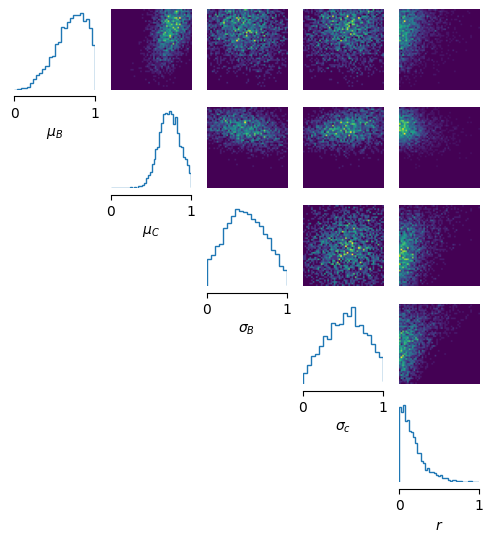

In [141]:
samples = posterior.sample((3000,), x=x_obs)

pairplot(samples,
             limits=[[0,1], [0,1], [0,1], [0,1], [0,1]],
             figsize=(6, 6),
             labels=[r"$\mu_B$", r"$\mu_C$", r"$\sigma_B$", r"$\sigma_c$", r"$r$"],
             )


In [142]:
samples.shape

mean=np.mean(samples.numpy(), axis=0) ; print(mean)

theta_estimated = np.array([mean]) ; theta_estimated=torch.tensor(theta_estimated) ; theta_estimated=theta_estimated.numpy()
#theta_estimated = np.array([[0.82769245, 0.7999444, 0.2, 0.2,  0.0919895]])
#print(theta_estimated[:,0])
x_estimated = simulator(theta_estimated,nb_simulations=1,nb_galaxies=2000000) ; print(x_estimated.shape)



[0.697849   0.72752637 0.47530827 0.53596646 0.17212877]


/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_40090/1953757310.py:71: RuntimeWarning: divide by zero encountered in divide
  K = np.sum(evcl[:,:,:,1][:,:,:,None] * (evcl/evls[:,:,None]), axis=2)
/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_40090/1953757310.py:71: RuntimeWarning: invalid value encountered in divide
  K = np.sum(evcl[:,:,:,1][:,:,:,None] * (evcl/evls[:,:,None]), axis=2)
/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_40090/1953757310.py:71: RuntimeWarning: invalid value encountered in multiply
  K = np.sum(evcl[:,:,:,1][:,:,:,None] * (evcl/evls[:,:,None]), axis=2)


(1, 99)


/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_40090/1953757310.py:82: RuntimeWarning: divide by zero encountered in divide
  a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*theta)))
/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_40090/1953757310.py:83: RuntimeWarning: divide by zero encountered in divide
  b_p = 1/np.sqrt(A1+C1-(1/a_p**2))
/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_40090/1953757310.py:86: RuntimeWarning: invalid value encountered in divide
  abs_e = (1-(b/a)) / (1+(b/a))


Text(0, 0.5, 'Normalized count')

<Figure size 1000x700 with 0 Axes>

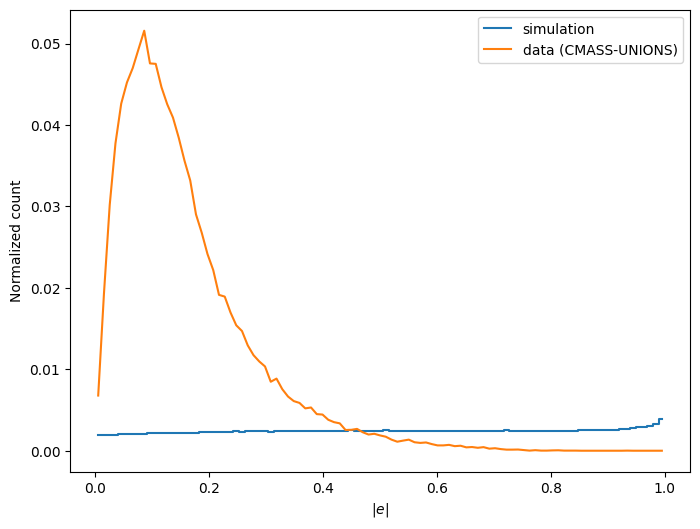

In [143]:
plt.figure( figsize = (10,7) )
plt.figure(figsize=(8,6))
plt.plot(e_cents,x_estimated[0,:],drawstyle='steps-mid',label='simulation')
plt.plot(e_cents,e_data_counts/nb_unions_cmass,label="data (CMASS-UNIONS)")
plt.legend()
plt.xlabel(r"$\vert e \vert$")
plt.ylabel("Normalized count")

Drawing 30000 posterior samples: 31716it [00:00, 56265.97it/s]                           


(<Figure size 600x600 with 25 Axes>,
 array([[<Axes: xlabel='$\\mu_B$'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: xlabel='$\\mu_C$'>, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='$\\sigma_B$'>, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='$\\sigma_c$'>,
         <Axes: >],
        [<Axes: xlabel='$\\mu_B$'>, <Axes: xlabel='$\\mu_C$'>,
         <Axes: xlabel='$\\sigma_B$'>, <Axes: xlabel='$\\sigma_c$'>,
         <Axes: xlabel='$r$'>]], dtype=object))

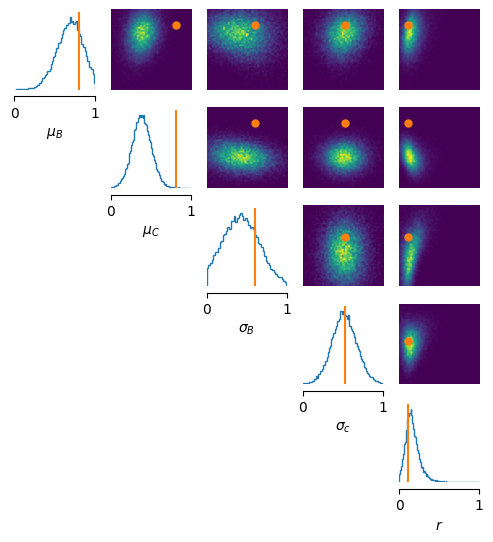

In [57]:
samples = posterior.sample((30000,), x=x_estimated)

pairplot(samples,
             points=theta_estimated,
             limits=[[0, 1], [0, 1], [0, 1], [0,1], [0,1]],
             figsize=(6, 6),
             labels=[r"$\mu_B$", r"$\mu_C$", r"$\sigma_B$", r"$\sigma_c$", r"$r$"],
             )